In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import scipy
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [4]:
# Enable GPU usage
print("Available GPUs:", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("GPU is enabled for training!")
    except Exception as e:
        print("Error enabling GPU:", e)
train = pd.read_csv(r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\written_name_validation_v2.csv')
valid = pd.read_csv(r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\written_name_test_v2.csv')


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is enabled for training!


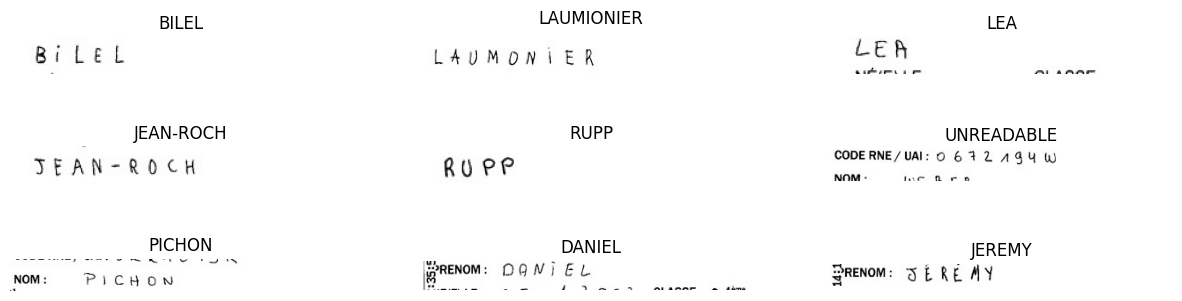

In [5]:
import os
import cv2
import matplotlib.pyplot as plt

# Base directory where images are stored
img_dir = r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\validation_v2\validation'

plt.figure(figsize=(15, 10))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    
    # Ensure the filename is correctly appended
    image_path = os.path.join(img_dir, train.loc[i, 'FILENAME'])

    # Check if the file exists
    if os.path.exists(image_path):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap='gray')
        plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    else:
        plt.title(f"Image {i+1} not found", fontsize=12)
    
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()


In [6]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  78
Number of NaNs in validation set :  70


In [7]:
train.dropna(axis=0, inplace=True)#axis =0, removing rows otherwisw axis =1. removing columns
valid.dropna(axis=0, inplace=True) #true means dropping

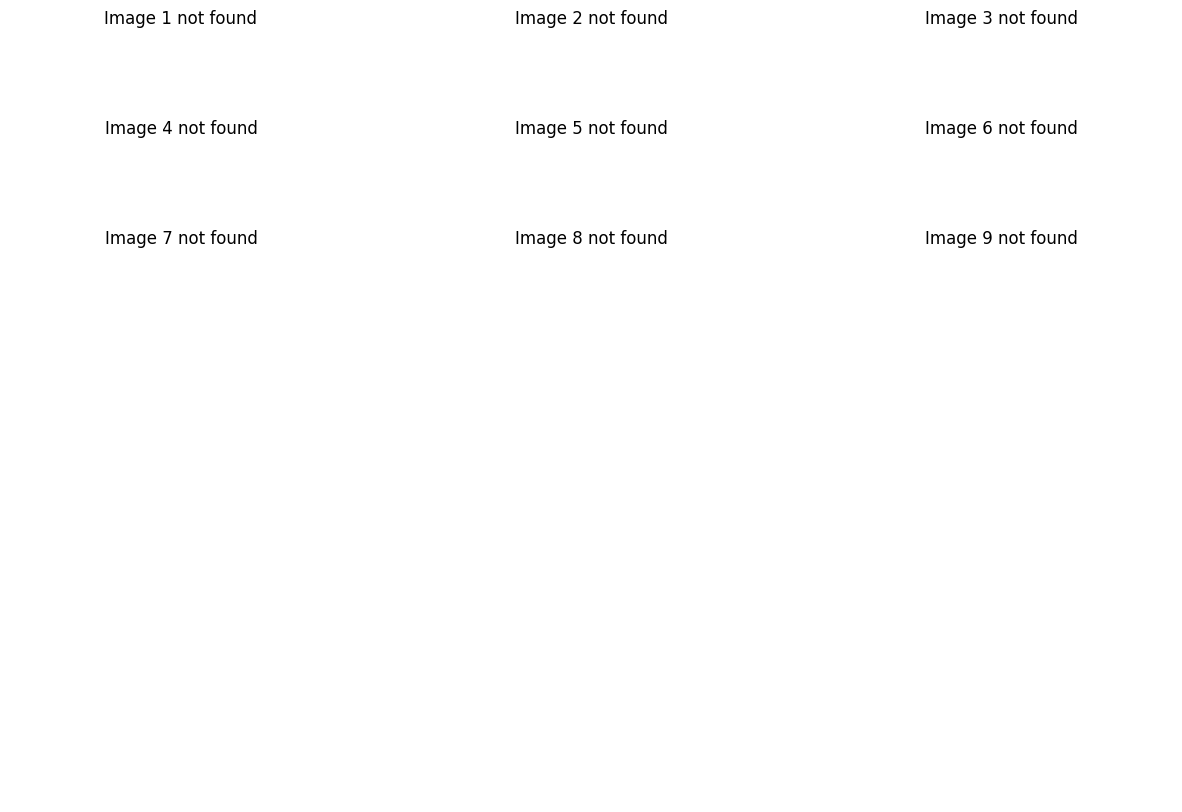

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

# Filter dataset for 'UNREADABLE' identity
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace=True, drop=True)

# Base directory
img_base_dir = r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\test_v2\test'

plt.figure(figsize=(15, 10))

for i in range(min(9, len(unreadable))):  # Ensure we don't exceed available images
    ax = plt.subplot(3, 3, i+1)
    
    # Properly join path with filename
    img_path = os.path.join(img_base_dir, unreadable.loc[i, 'FILENAME'])

    # Check if the file exists before loading
    if os.path.exists(img_path):
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(image, cmap='gray')
        plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    else:
        plt.title(f"Image {i+1} not found", fontsize=12)
    
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()


In [9]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
valid

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN
...,...,...
41365,TEST_41366.jpg,ALEXANE
41366,TEST_41367.jpg,PEREIRA-SILVA
41367,TEST_41368.jpg,LAURENT
41368,TEST_41369.jpg,DEFFENSE


In [10]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [11]:

train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [12]:
import numpy as np
import cv2

def preprocess(img):
    img = cv2.resize(img, (256, 64))  # (width, height)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # (64, 256, 1)
    img = np.transpose(img, (1, 0, 2))  # Make it (256, 64, 1)
    return img

# Load sample image (make sure this image exists)
test_img = cv2.imread(r"C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\test_v2\test\TEST_0001.jpg", cv2.IMREAD_GRAYSCALE)

if test_img is None:
    print("⚠️ Error: Could not load image. Check the file path!")
else:
    preprocessed_img = preprocess(test_img)
    print("Image shape after preprocess:", preprocessed_img.shape)


Image shape after preprocess: (256, 64, 1)


In [13]:
 
# Set image directories
train_dir = r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\validation_v2\validation'
valid_dir = r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\test_v2\test'

# Count only existing files
train_size = sum(os.path.exists(os.path.join(train_dir, f)) for f in train['FILENAME'])
valid_size = sum(os.path.exists(os.path.join(valid_dir, f)) for f in valid['FILENAME'])

print(f"✅ Train size: {train_size}")
print(f"✅ Validation size: {valid_size}")

✅ Train size: 41280
✅ Validation size: 41289


In [14]:
import os
import pandas as pd

# Path to your image directory
image_dir = r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\validation_v2\validation'

# Path to your CSV file (ensure you have the correct file path)
csv_path =r'C:\Users\91780\PycharmProjects\PostAutoMate\data\handwriting_dataset\written_name_validation_v2.csv'

# Load your CSV into a DataFrame
train = pd.read_csv(csv_path)

# Get the number of rows in the CSV (this represents the number of entries)
csv_rows = len(train)
print(f"Number of entries in CSV: {csv_rows}")

# Get the list of image filenames in the image directory
image_files = os.listdir(image_dir)

# Filter only image files (you can adjust the extension check based on your file type)
image_files = [f for f in image_files if f.endswith('.jpg') or f.endswith('.png')]  # Adjust based on your image type

# Get the number of images in the image directory
num_images = len(image_files)
print(f"Number of images in directory: {num_images}")

# Optionally, compare if the number of images matches the number of entries in the CSV
if csv_rows == num_images:
    print("The number of images matches the number of entries in the CSV.")
else:
    print(f"Warning: The number of images does not match the number of entries in the CSV. CSV rows: {csv_rows}, Images: {num_images}")


Number of entries in CSV: 41370
Number of images in directory: 41370
The number of images matches the number of entries in the CSV.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with preprocessing
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train, 
    directory="C:/Users/91780/PycharmProjects/PostAutoMate/data/handwriting_dataset/validation_v2/validation",
    x_col="FILENAME", 
    target_size=(64, 256),  # Change this
    color_mode="grayscale",
    batch_size=32, 
    class_mode=None
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=valid, 
    directory="C:/Users/91780/PycharmProjects/PostAutoMate/data/handwriting_dataset/test_v2/test",
    x_col="FILENAME", 
    target_size=(64, 256),  # Change this
    color_mode="grayscale",
    batch_size=32, 
    class_mode=None
)


 


Found 41370 validated image filenames.
Found 41289 validated image filenames.


In [16]:
alphabets = u"!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz " 
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank(epsilon)
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        idx = alphabets.find(ch)
        if idx != -1:
            label_num.append(idx)
        else:
            print(f"⚠️ Skipping unsupported character: {ch} in label '{label}'")
            # You can choose to skip or raise an error
            # raise ValueError(f"Unsupported character: {ch}")
    return np.array(label_num, dtype=np.int32)


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret
 



In [17]:
name = 'Ankur'
print(name, '\n',label_to_num(name))


Ankur 
 [26 65 62 72 69]


In [18]:
import numpy as np

# Assuming 'train_size' is the total number of samples
train_size = len(train)

# Maximum length of output sequence
max_str_len = 24  # Adjust as per your dataset

# Number of time steps in the model
num_of_timestamps = 64  

# Initialize arrays
train_y = np.ones([train_size, max_str_len]) * -1  # Padding with -1
train_label_len = np.zeros([train_size, 1])  # Stores actual label lengths
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps - 2)  # Input sequence length
train_output = np.zeros([train_size])  # Placeholder (not used in CTC loss)

# Process labels
for i in range(train_size):
    identity = train.loc[i, 'IDENTITY']  # Extract label

    if not isinstance(identity, str):  
        identity = ""  # Ensure it's a valid string

    # Convert label to numerical encoding
    label_encoded = label_to_num(identity)

    # Trim if label is too long
    label_encoded = label_encoded[:max_str_len]

    # Store label length
    train_label_len[i] = len(label_encoded)

    # Assign labels safely (with proper bounds)
    train_y[i, :len(label_encoded)] = label_encoded  

# Print shape for verification
print("train_y shape:", train_y.shape)
print("train_label_len shape:", train_label_len.shape)
print("train_input_len shape:", train_input_len.shape)


train_y shape: (41370, 24)
train_label_len shape: (41370, 1)
train_input_len shape: (41370, 1)


In [19]:
valid_size = valid.shape[0]  # Ensure valid_size matches actual row count
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps - 2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):  
    identity = valid.iloc[i]['IDENTITY']  # Safe indexing  
    valid_label_len[i] = len(identity)  
    valid_y[i, 0:len(identity)] = label_to_num(identity)  
print(f"valid_size: {valid_size}, actual rows: {valid.shape[0]}")


valid_size: 41289, actual rows: 41289


In [20]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])


True label :  GABRIELLE 
train_y :  [32. 26. 27. 43. 34. 30. 37. 37. 30. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [9.] 
train_input_len :  [62.]


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, Dense, Bidirectional, LSTM
from tensorflow.keras.models import Model

# Input
input_data = Input(shape=(256, 64, 1), name='input')  # Update shape


# CNN Feature Extractor
inner = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)

inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2))(inner)
inner = Dropout(0.3)(inner)

# Reshape for RNN
inner = Reshape(target_shape=(64, -1), name='reshape')(inner)  # Auto-adjust features

# RNN Sequence Processing
inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(128, return_sequences=True), name='lstm2')(inner)

# Output Layer
inner = Dense(num_of_characters, kernel_initializer='he_normal')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

# Model
model = Model(inputs=input_data, outputs=y_pred)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 32, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 32, 64)       18496 

In [22]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [23]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

# Add CTC-specific inputs
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

# CTC loss layer
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Add Lambda layer for computing CTC loss
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

# Final training model (includes extra inputs only used during training)
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)


In [24]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
#file_path_best = "C_LSTM_best2.hdf5"

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate = 0.0001))

checkpoint = ModelCheckpoint(filepath=file_path_best, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

NameError: name 'file_path_best' is not defined

In [32]:
import numpy as np
import os
import cv2
import tensorflow.keras.backend as K
from tensorflow import keras

# Replace with your actual values or make them arguments
max_str_len = 24  # Example: Max label length
num_of_timestamps = 64  # Should match model's output time steps
batch_size = 32  # Can be modified

class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, dataframe, directory, batch_size=32, img_size=(64, 256), shuffle=True):
        self.dataframe = dataframe
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.dataframe))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.dataframe.iloc[batch_indices]

        # Remove empty or invalid labels
        batch_data = batch_data[batch_data["IDENTITY"].notna()]
        batch_data = batch_data[batch_data["IDENTITY"].str.len() > 0]

        # Avoid CTC error: ensure at least one sample remains
        if len(batch_data) == 0:
            print(f"⚠️ Skipping batch {index} due to empty labels.")
            return self.__getitem__((index + 1) % self.__len__())

        return self.__data_generation(batch_data)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_data):
        batch_len = len(batch_data)

        X = np.ones((batch_len, self.img_size[1], self.img_size[0], 1)) * 255
        Y = np.zeros((batch_len, max_str_len), dtype=np.int32)  # Use 0 padding instead of -1
        input_length = np.ones((batch_len, 1)) * (num_of_timestamps - 2)
        label_length = np.zeros((batch_len, 1))

        valid_idx = 0

        for _, row in batch_data.iterrows():
            img_path = os.path.join(self.directory, row["FILENAME"])
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None or not isinstance(row["IDENTITY"], str) or len(row["IDENTITY"]) == 0:
                continue

            img = preprocess(img)  # Ensure output shape is (64, 256, 1)
            X[valid_idx] = img

            label = label_to_num(row["IDENTITY"])[:max_str_len]
            if len(label) == 0:
                continue

            Y[valid_idx, :len(label)] = label
            label_length[valid_idx] = len(label)
            valid_idx += 1

        if valid_idx == 0:
            print("⚠️ Entire batch invalid — returning dummy data.")
            return self.__getitem__((np.random.randint(0, self.__len__())))

        return [X[:valid_idx], Y[:valid_idx], input_length[:valid_idx], label_length[:valid_idx]], np.zeros(valid_idx)


# 👇 Assuming these functions exist
# def preprocess(image): ...
# def label_to_num(text): ...

# ✅ Create generators
train_generator = CustomDataGenerator(train, "C:/Users/91780/PycharmProjects/PostAutoMate/data/handwriting_dataset/validation_v2/validation")
valid_generator = CustomDataGenerator(valid, "C:/Users/91780/PycharmProjects/PostAutoMate/data/handwriting_dataset/test_v2/test")

 


In [38]:
from tensorflow.keras.models import load_model
model = load_model("inference_model1.h5", compile=False)  

In [40]:
# Fetch one batch from validation generator
(X, Y, _, label_length), _ = valid_generator[0]

# Predict
preds = model.predict(X)

# Decode with CTC
from tensorflow.keras.backend import ctc_decode
decoded, _ = ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1], greedy=True)
decoded_labels = decoded[0].numpy()

# Convert predictions and ground truths to text
pred_texts = [num_to_label(seq) for seq in decoded_labels]
true_texts = [num_to_label(label[:int(length[0])]) for label, length in zip(Y, label_length)]


1/1 [==============================] - 17s 17s/step


In [42]:
import editdistance

def cer(ref, hyp):
    return editdistance.eval(ref, hyp) / len(ref) if len(ref) > 0 else 0

def wer(ref, hyp):
    ref_words = ref.split()
    hyp_words = hyp.split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words) if len(ref_words) > 0 else 0


In [44]:
total_cer, total_wer = 0, 0
n = len(true_texts)

for ref, hyp in zip(true_texts, pred_texts):
    total_cer += cer(ref, hyp)
    total_wer += wer(ref, hyp)

avg_cer = total_cer / n
avg_wer = total_wer / n

print(f"\n✅ Average CER: {avg_cer:.4f}")
print(f"✅ Average WER: {avg_wer:.4f}")



✅ Average CER: 0.0392
✅ Average WER: 0.2188


In [46]:
from jiwer import cer, wer

# Lists to store predicted and true texts
y_pred = []
y_true = []

# Get predictions from model
for batch in valid_generator:
    # Get inputs
    images, labels, input_len, label_len = batch[0]
    
    # Predict
    preds = model.predict(images)
    
    # Decode using CTC (greedy decoder here)
    decoded = K.ctc_decode(preds, input_length=np.ones(preds.shape[0]) * preds.shape[1],
                           greedy=True)[0][0]
    
    decoded_preds = []
    for pred in decoded.numpy():
        decoded_preds.append(num_to_label(pred))

    # Convert true labels to string
    for i in range(len(decoded_preds)):
        pred_text = decoded_preds[i]
        true_label = labels[i][:int(label_len[i][0])]  # ✅ fixed index
        true_text = num_to_label(true_label)

        y_pred.append(pred_text)
        y_true.append(true_text)

    break  # Remove this `break` to evaluate over full validation set
avg_cer = cer(y_true, y_pred)
avg_wer = wer(y_true, y_pred)

print(f"✅ Average CER: {avg_cer:.4f}")
print(f"✅ Average WER: {avg_wer:.4f}")


1/1 [==============================] - 0s 108ms/step
✅ Average CER: 0.0457
✅ Average WER: 0.2188


In [48]:
from tensorflow.keras.models import load_model
from tensorflow.keras.backend import ctc_decode
import pandas as pd

# Load your saved model (if not already in memory)
model = load_model("inference_model1.h5", compile=False)

# Pick some samples from validation set to test
sample_batch = next(iter(valid_generator))
X_test = sample_batch[0][0]
y_true = sample_batch[0][1]

# Predict
y_pred = model.predict(X_test)

# Decode predictions using best path decoding (greedy)
decoded, _ = ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0]) * y_pred.shape[1], greedy=True)
decoded_labels = decoded[0].numpy()

# Convert predictions and ground truth to text
predicted_texts = [num_to_label(label) for label in decoded_labels]
true_texts = [num_to_label(label[label != 0]) for label in y_true]

# Save or print
df = pd.DataFrame({
    "Ground Truth": true_texts,
    "Predicted": predicted_texts
})

print(df.head(10))  # Show first 10 results

# Optional: Save to CSV
df.to_csv("predictions_vs_truth.csv", index=False)
print("save")

1/1 [==============================] - 3s 3s/step
  Ground Truth Predicted
0       HELARY    HELARY
1      ESTELLE   ESTELLE
2        CHERU     CHERU
3     LOGHRIEB  LOGHRIEB
4     THIBAULT  THIBAULT
5         ZHOU      ZHOU
6      CROUTTE   CROUTTE
7      ROTKOPF   ROTKOPF
8       NOEMIE    NOEMIE
9      FLORIAN   FUORIAN
save


In [70]:
imgsize=(64,256)
num_of_timestamps=64
 
    

def decode(pred):
    decoded,_=ctc_decode(pred,input_length=np.ones(pred.shape[0])*num_of_timestamps,greedy=True)
    decode_text=num_to_label(decoded[0][0].numpy())
    return decode_text
img_path=r"C:/Users/91780/PycharmProjects/PostAutoMate/data/handwriting_dataset/test_v2/test/TEST_0001.jpg"
def preimg(img_path):
    img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("nothing")
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # (64, 256, 1)
    img = np.transpose(img, (1, 0, 2))  # Make it (256, 64, 1)
    img=np.expand_dims(img,axis=0)
    return img
image=preimg(img_path)
pred=model.predict(image)
predict=decode(pred)
print(predict)

1/1 [==============================] - 0s 104ms/step
K
